In [24]:
# Import modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.datasets import load_boston # For example
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time
import pandas as pd

In [26]:
# Define ANN parameters
n_hidden_layers = 2 # Number of hidden layers
n_hidden_nodes = [64 ,32] # Number of hidden nodes for each hidden layer
activation_function = 'relu' # Activation function for hidden nodes
loss_function = 'mean_squared_error' # Loss function
optimizer = 'adam' # Optimizer
learning_rate = 0.001 # Learning rate
batch_size = 32 # Batch size
epoch = 100 # Epoch

In [28]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('./housing.data', delimiter=r"\s+", header=None, names=column_names)

X = data.drop(columns='MEDV')
y = data['MEDV']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2)

In [35]:
# Scale the data to have values between 0 and 1
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

4/4 [==============================] - 0s 3ms/step
MSE: 14.769882054909692
Training time: 6.53436279296875
Prediction time: 0.13204193115234375


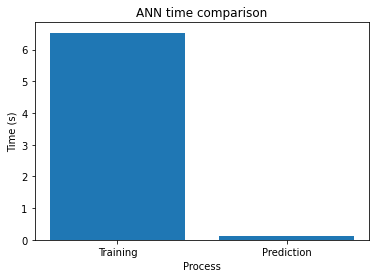

In [43]:
# Create the architecture of the ANN model using keras Sequential class
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=X.shape[1])) # Input layer
for i in range(n_hidden_layers):
    model.add(layers.Dense(n_hidden_nodes[i] , activation=activation_function)) # Hidden layer
model.add(layers.Dense(1)) # Output layer

# Compile the ANN model with the specified loss function , optimizer , learning rate , and evaluation metric
model.compile(loss=loss_function , optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mean_squared_error'])

# Train the ANN model using keras fit method and measure the training time using time module
start_time = time.time()
history = model.fit(X_train_scaled , y_train , batch_size=batch_size , epochs=epoch , validation_data=(X_test_scaled , y_test) , verbose=0)
end_time = time.time()
training_time = end_time - start_time

# Save the trained ANN model to a file or another source
# model.save("ann_model.h5")

# Predict the outputs of the testing data using the trained ANN model and measure the prediction time using time module
start_time = time.time()
y_pred = model.predict(X_test_scaled)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate the evaluation metric for the predictions of the testing data
mse = mean_squared_error(y_test, y_pred) 
print("MSE:", mse)
# Print or plot the training time and prediction time
print("Training time:", training_time) 
print("Prediction time:", prediction_time) 
plt.bar(["Training", "Prediction"], [training_time, prediction_time]) 
plt.xlabel("Process") 
plt.ylabel("Time (s)") 
plt.title("ANN time comparison") 
plt.show()

In [124]:
# Import libraries
import tensorflow as tf
import numpy as np
# from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load and preprocess data
X = data.drop(columns='MEDV')
y = data['MEDV'].values.reshape(-1,1)

scaler_X = StandardScaler()
# scaler_y = StandardScaler()
X = tf.cast(scaler_X.fit_transform(X), tf.float32)
# y = tf.cast(scaler_y.fit_transform(y), tf.float32)

# # Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [148]:
# Define ELM-CSO class
class ELM_CSO:
    def __init__(self, n_input, n_hidden, n_output):
        # Initialize parameters
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.input_weights = tf.Variable(tf.random.normal([n_input, n_hidden]), trainable=False)
        self.output_weights = tf.Variable(tf.random.normal([n_hidden, n_output]), trainable=True)
        self.bias = tf.Variable(tf.zeros([n_hidden]), trainable=False)
        self.activation = tf.nn.relu

    def forward(self, X):
        # Compute hidden layer output
        H = self.activation(tf.matmul(X, self.input_weights) + self.bias)
        # Compute output layer output
        O = tf.matmul(H, self.output_weights)
        return O

    def train(self, X_train, y_train, X_test, y_test, n_iter, n_pop):
        # Define optimizer and loss function
        optimizer = tf.optimizers.Adam()
        loss_fn = tf.losses.MeanSquaredError()

        # Define CSO parameters
        c1 = 1.49445 # cognitive parameter
        c2 = 1.49445 # social parameter
        w = 0.729 # inertia weight

        # Initialize population and velocities
        pop = tf.Variable(tf.random.uniform([n_pop, self.n_input * self.n_hidden + self.n_hidden], -1, 1))
        vel = tf.Variable(tf.random.uniform([n_pop, self.n_input * self.n_hidden + self.n_hidden], -1, 1))

        # Initialize personal best and global best positions and fitnesses
        pbest_pos = tf.Variable(pop)
        pbest_fit = tf.Variable(tf.ones([n_pop]) * np.inf)
        gbest_pos = None
        gbest_fit = np.inf

        # Start iterations
        for i in range(n_iter):
            # Evaluate fitness of each particle
            for j in range(n_pop):
                # Decode particle position to input weights and bias
                self.input_weights.assign(tf.reshape(pop[j][:self.n_input * self.n_hidden], [self.n_input, self.n_hidden]))
                self.bias.assign(pop[j][self.n_input * self.n_hidden:])

                # Train output weights with one-step learning
                H_train = self.activation(tf.matmul(X_train, self.input_weights) + self.bias)
                H_train_pinv = tf.linalg.pinv(H_train)
                self.output_weights.assign(tf.matmul(H_train_pinv, y_train))

                # Compute training loss
                y_pred_train = self.forward(X_train)
                loss_train = loss_fn(y_train, y_pred_train)

                # Update personal best position and fitness if improved
                if loss_train < pbest_fit[j]:
                    pbest_pos[j].assign(pop[j])
                    pbest_fit[j].assign(loss_train)

                    # Update global best position and fitness if improved
                    if loss_train < gbest_fit:
                        gbest_pos = pop[j]
                        gbest_fit = loss_train

            # Update velocities and positions of each particle
            for j in range(n_pop):
                vel[j].assign(w * vel[j] + c1 * tf.random.uniform([1]) * (pbest_pos[j] - pop[j]) + c2 * tf.random.uniform([1]) * (gbest_pos - pop[j]))
                pop[j].assign(pop[j] + vel[j])

            # Compute test loss and print progress
            y_pred_test = self.forward(X_test)
            loss_test = loss_fn(y_test, y_pred_test)
            print(f"Iteration {i+1}, Train Loss: {gbest_fit.numpy():.4f}, Test Loss: {loss_test.numpy():.4f}")

    def predict(self, X):
        # Predict output given input
        return self.forward(X)

# Create ELM-CSO model with 10 hidden neurons
model = ELM_CSO(n_input=13, n_hidden=150, n_output=1)

# Train model with 100 iterations and 50 particles
model.train(X_train, y_train, X_test, y_test, n_iter=50, n_pop=50)

# Predict output for test set and compute RMSE
y_pred_test_CSO_ELM = model.predict(X_test)
# y_pred_test = scaler_y.inverse_transform(y_pred_test)
# y_test = scaler_y.inverse_transform(y_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_CSO_ELM))
mse_test = mean_squared_error(y_test, y_pred_test_CSO_ELM)
r_squared_test = r2_score(y_test, y_pred_test_CSO_ELM)
mae_test = mean_absolute_error(y_test, y_pred_test_CSO_ELM)

# Print results
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test r_squared: {r_squared_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")

Iteration 1, Train Loss: 3.4267, Test Loss: 110.0405
Iteration 2, Train Loss: 3.2693, Test Loss: 219.6781
Iteration 3, Train Loss: 3.0977, Test Loss: 162.7546
Iteration 4, Train Loss: 2.9816, Test Loss: 135.7402
Iteration 5, Train Loss: 2.8641, Test Loss: 169.6694
Iteration 6, Train Loss: 2.8204, Test Loss: 148.1327
Iteration 7, Train Loss: 2.8154, Test Loss: 310.3142
Iteration 8, Train Loss: 2.7841, Test Loss: 279.9182
Iteration 9, Train Loss: 2.7841, Test Loss: 158.1033
Iteration 10, Train Loss: 2.7841, Test Loss: 147.4955
Iteration 11, Train Loss: 2.7600, Test Loss: 234.4652
Iteration 12, Train Loss: 2.7039, Test Loss: 240.7809
Iteration 13, Train Loss: 2.6591, Test Loss: 180.0783
Iteration 14, Train Loss: 2.6356, Test Loss: 137.1224
Iteration 15, Train Loss: 2.6216, Test Loss: 136.7918
Iteration 16, Train Loss: 2.6128, Test Loss: 155.9704
Iteration 17, Train Loss: 2.5742, Test Loss: 139.9515
Iteration 18, Train Loss: 2.5634, Test Loss: 141.3668
Iteration 19, Train Loss: 2.5565, Tes

In [216]:
# Import libraries
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

# Load and preprocess data
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)
scaler_X = StandardScaler()
encoder_y = OneHotEncoder()
X = scaler_X.fit_transform(X)
X = tf.cast(scaler_X.fit_transform(X), tf.float32)
y = encoder_y.fit_transform(y).toarray()

# Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define ELM-CSO class
class ELM_CSO:
    def __init__(self, n_input, n_hidden, n_output, activation, problem_type):
        # Initialize parameters
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.input_weights = tf.Variable(tf.random.normal([n_input, n_hidden]), trainable=False)
        self.output_weights = tf.Variable(tf.random.normal([n_hidden, n_output]), trainable=True)
        self.bias = tf.Variable(tf.zeros([n_hidden]), trainable=False)
        # Change activation function to tanh
        self.activation = activation
        self.problem_type = problem_type

    def forward(self, X):
        # Compute hidden layer output
        H = self.activation(tf.matmul(X, self.input_weights) + self.bias)
        # Compute output layer output with conditional activation function
        if self.problem_type == 'regression':
            O = tf.matmul(H, self.output_weights)
        elif self.problem_type == 'classification':
            # Check if output neuron is 1 or more
            if self.n_output == 1:
                # Use sigmoid activation for binary classification
                O = tf.nn.sigmoid(tf.matmul(H, self.output_weights))
            else:
                # Use softmax activation for multiclass classification
                O = tf.nn.softmax(tf.matmul(H, self.output_weights))
        else:
            raise ValueError("Invalid problem type. Must be either 'regression' or 'classification'.")
        return O


    def train(self, X_train, y_train, X_test, y_test, n_iter, n_pop, loss_function, optimizer):
        # Define optimizer and loss function
        optimizer = optimizer
        # Change loss function to categorical crossentropy
        loss_fn = loss_function

        # Define CSO parameters
        c1 = 1.49445 # cognitive parameter
        c2 = 1.49445 # social parameter
        w = 0.729 # inertia weight

        # Initialize population and velocities as variables
        pop = tf.Variable(tf.random.uniform([n_pop, self.n_input * self.n_hidden + self.n_hidden], -1, 1))
        vel = tf.Variable(tf.random.uniform([n_pop, self.n_input * self.n_hidden + self.n_hidden], -1, 1))

        # Initialize personal best and global best positions and fitnesses as variables
        pbest_pos = tf.Variable(pop)
        pbest_fit = tf.Variable(tf.ones([n_pop]) * np.inf)
        gbest_pos = None
        gbest_fit = np.inf

        # Start iterations
        for i in range(n_iter):
            # Evaluate fitness of each particle
            for j in range(n_pop):
                # Decode particle position to input weights and bias
                self.input_weights.assign(tf.reshape(pop[j][:self.n_input * self.n_hidden], [self.n_input, self.n_hidden]))
                self.bias.assign(pop[j][self.n_input * self.n_hidden:])

                # Train output weights with one-step learning
                H_train = self.activation(tf.matmul(X_train, self.input_weights) + self.bias)
                H_train_pinv = tf.linalg.pinv(H_train)
                self.output_weights.assign(tf.matmul(H_train_pinv, y_train))

                # Compute training loss
                # Train output weights with gradient-based learning
                with tf.GradientTape() as tape:
                    y_pred_train = self.forward(X_train)
                    loss_train = loss_fn(y_train, y_pred_train)
                gradients = tape.gradient(loss_train, self.output_weights)
                optimizer.apply_gradients(zip([gradients], [self.output_weights]))
                # y_pred_train = self.forward(X_train)
                # loss_train = loss_fn(y_train, y_pred_train)

                # Update personal best position and fitness if improved
                if loss_train < pbest_fit[j]:
                    pbest_pos[j].assign(pop[j])
                    pbest_fit[j].assign(loss_train)

                    # Update global best position and fitness if improved
                    if loss_train < gbest_fit:
                        gbest_pos = pop[j]
                        gbest_fit = loss_train

            # Update velocities and positions of each particle
            for j in range(n_pop):
                vel[j].assign(w * vel[j] + c1 * tf.random.uniform([1]) * (pbest_pos[j] - pop[j]) + c2 * tf.random.uniform([1]) * (gbest_pos - pop[j]))
                pop[j].assign(pop[j] + vel[j])

            # Compute test loss and print progress
            y_pred_test = self.forward(X_test)
            loss_test = loss_fn(y_test, y_pred_test)
            print(f"Iteration {i+1}, Train Loss: {gbest_fit.numpy():.4f}, Test Loss: {loss_test.numpy():.4f}")

    def predict(self, X):
        # Predict output given input
        return self.forward(X)

# Create ELM-CSO model with 10 hidden neurons and 3 output neurons
model = ELM_CSO(n_input=4, n_hidden=10, n_output=3, activation=tf.nn.relu, problem_type='classification')

# Train model with 100 iterations and 50 particles
model.train(X_train, y_train, X_test, y_test, n_iter=10, n_pop=510, loss_function=tf.losses.CategoricalCrossentropy(), optimizer=tf.optimizers.Adam())

# Predict output for test set and compute accuracy score
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test.numpy(), axis=1)
y_test = np.argmax(y_test, axis=1)
acc_test = accuracy_score(y_test,y_pred_test)
print(f"Test Accuracy: {acc_test:.4f}")

Iteration 1, Train Loss: 0.5904, Test Loss: 0.8118
Iteration 2, Train Loss: 0.5836, Test Loss: 0.8245
Iteration 3, Train Loss: 0.5799, Test Loss: 0.7851
Iteration 4, Train Loss: 0.5791, Test Loss: 0.7288
Iteration 5, Train Loss: 0.5788, Test Loss: 0.7256
Iteration 6, Train Loss: 0.5785, Test Loss: 0.7304
Iteration 7, Train Loss: 0.5780, Test Loss: 0.7402
Iteration 8, Train Loss: 0.5772, Test Loss: 0.7693
Iteration 9, Train Loss: 0.5770, Test Loss: 0.7410
Iteration 10, Train Loss: 0.5759, Test Loss: 0.7199
Test Accuracy: 0.9333


In [145]:
# # Define ANN model with 10 hidden neurons and 1 output neuron
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(33, activation='relu', input_shape=(13,)),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

# # Compile model with Adam optimizer and MSE loss function
# model.compile(optimizer='adam', loss='mse')

# # Train model with 100 epochs and batch size of 32
# model.fit(X_train, y_train, epochs=100, batch_size=32)

# # Predict output for test set and compute metrics
# # Predict output for test set and compute RMSE
# y_pred_test = model.predict(X_test)
# # y_pred_test = scaler_y.inverse_transform(y_pred_test)
# # y_test = scaler_y.inverse_transform(y_test)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
# mse_test = mean_squared_error(y_test, y_pred_test)
# r_squared_test = r2_score(y_test, y_pred_test)
# mae_test = mean_absolute_error(y_test, y_pred_test)

# # Print results
# print(f"Test RMSE: {rmse_test:.4f}")
# print(f"Test MSE: {mse_test:.4f}")
# print(f"Test r_squared: {r_squared_test:.4f}")
# print(f"Test MAE: {mae_test:.4f}")

Epoch 1/100
13/13 [==============================] - 1s 3ms/step - loss: 666.7123
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 646.2822
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 625.1475
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 601.4096
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 571.9343
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 534.8645
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 486.3061
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 425.5171
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 352.6940
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 275.4070
Epoch 11/100
13/13 [==============================] - 0s 6ms/step - loss: 203.3209
Epoch 12/100
13/13 [==============================] - 0s 6ms/step - loss: 145.2121
Epoch 13/100


In [204]:
pd.set_option('display.max_rows', None)

y_test_df = pd.DataFrame(y_test, columns=['y test'])
y_pred_df = pd.DataFrame(y_pred_test, columns=['y pred'])

pd.concat([y_test_df, y_pred_df], axis=1)

,y test,y pred
0,2,2
1,2,2
2,2,2
3,2,2
4,2,2
5,2,2
6,2,2
7,2,2
8,2,2
9,2,2
